In [1]:
# import libraries
import pandas as pd
import numpy as np
import pyspark.sql.functions as F

from sklearn.preprocessing import StandardScaler
from pyspark.sql.types import StringType, IntegerType, LongType
from pyspark.sql.functions import col

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

scaler = StandardScaler()

In [2]:
# start spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("yarn").appName("va8").getOrCreate()

In [ ]:
# open txt file
path="working_file.txt"
df_total=spark.read \
  .option("header", "True") \
  .option("escape", "\"") \
  .option("delimiter", "|") \
  .csv(path)

In [ ]:
# simple check what values can we find in Column4 column

# import numpy as np
# testowane = df_total.select('Column4').groupBy('Column4').count()

# testowane = testowane.withColumn('ratio', F.col('count')/testowane.groupBy().sum().collect()[0][0])   
# testowane = testowane.withColumn('count',F.format_number('count',0)).toPandas()
# testowane = np.round(testowane, decimals=2)
# testowane

In [9]:
# use only 10% of our data set
df = df_total.sample(0.1, seed = 56)

In [11]:
# remove dates that are older that 1901
df = df.filter(F.col('Column1')>=19010000)

In [12]:
# change format to date
df = df.withColumn('Column1', F.to_date(F.col('Column1'), 'YYYYMMdd')) \
       .withColumn('Column2', F.to_date(F.col('Column2'), 'YYYYMMdd'))

In [13]:
# work with formats: from Column1, Column2 extract only year; Column7&8 split into two separate columns
df = df.withColumn("Column1_year", df["Column1"].cast(StringType())) 
df = df.withColumn('Column1_year', F.substring(df['Column1_year'],1,4))
df = df.withColumn('Column1_year', df['Column1_year'].cast(IntegerType()))

df = df.withColumn("Column2_year", df["Column2"].cast(StringType())) 
df = df.withColumn('Column2_year', F.substring(df['Column2_year'],1,4))
df = df.withColumn('Column2_year', df['Column2_year'].cast(IntegerType()))

df = df.withColumn("Column7&8", F.split("Column7&8", " ")) \
       .withColumn("Column7", F.col('Column7&8')[0]) \
       .withColumn('Column8', F.col('Column7&8')[1]) \
       .drop('Column7&8') \
       .fillna('None', subset=['Column4']) \
       .withColumnRenamed('Column1_year', 'label') 

In [14]:
# filter values that are not equall null
df = df.filter(F.col('Column2_year').isNotNull())
df = df.filter(F.col('Column7').isNotNull())
df = df.filter(F.col('Column8').isNotNull())

df = df.withColumn('Column7', F.when(F.col('Column7') == "",'Null').otherwise(F.col('Column7')))

In [15]:
# use OneHotEncoder to convert categorical columns into vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

list_of_cols = ['Column4','Column3', 'Column5', 'Column8', 'Column6', 'Column7']

stringIndexer = [StringIndexer(inputCol=i, outputCol=i + "_index").fit(df) for i in list_of_cols]

encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="job_vec_"+indexer.getOutputCol()) for indexer in stringIndexer]

list_of_encoders = [encoder.getOutputCol() for encoder in encoders]
list_of_encoders.insert(0,"Column2_year")

vector_assembler = VectorAssembler(inputCols=list_of_encoders, outputCol="features")

pipeline = Pipeline(stages = stringIndexer + encoders + [vector_assembler])
model = pipeline.fit(df)
df = model.transform(df)

In [17]:
# initiate model Gradient Boosted Tree Regression

#from pyspark import SparkContext
#from pyspark.sql import SQLContext
from pyspark.ml.regression import GBTRegressor

va_df = df.select(['features','label'])
(train, test) = va_df.randomSplit([0.8, 0.2], seed=123)

gbtr = GBTRegressor(featuresCol='features', labelCol='label', maxIter=10)
gbtr = gbtr.fit(train)

In [ ]:
mdata = gbtr.transform(test)
mdata.show(3)
 
rmse=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(mdata) 
 
mae=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae=mae.evaluate(mdata) 
 
r2=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(mdata)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

In [22]:
# prepare data to visualize (how many records were predicted correctly)
prediction = mdata.select('label','prediction')
prediction = prediction.withColumn('prediction', F.round(F.col('prediction'),0))
prediction = prediction.withColumn('check', F.when(F.col('label') == F.col('prediction'),1).otherwise(0))
prediction = prediction.withColumn('difference', F.col('label') - F.col('prediction'))

In [23]:
# add new column with labels
prediction = prediction.withColumn('bucket', 
                                   F.when(F.col('difference')<-20,'-21 or more')
                                   .when((F.col('difference')>-21) & (F.col('difference')<-10), '-11 to -20')
                                   .when((F.col('difference')>-11) & (F.col('difference')<0), '-1 to -10')
                                   .when(F.col('difference') == 0, '0')
                                   .when((F.col('difference')>0) & (F.col('difference')<11), '1 to 10')
                                   .when((F.col('difference')>10) & (F.col('difference')<21), '11 to 20')
                                   .when(F.col('difference')>20,'21 or more')
                                  )

In [24]:
# create table for chart
final_view = prediction.select('bucket').groupBy('bucket').count() 
final_view = final_view.withColumn('count', F.col('count')/final_view.groupBy().sum().collect()[0][0])
final_view = final_view.toPandas().reindex([3,1,6,0,4,5,2])
final_view = np.round(final_view, decimals=2)
final_view

,bucket,count
3,-21 or more,0.11
1,-11 to -20,0.15
6,-1 to -10,0.24
0,0,0.02
4,1 to 10,0.21
5,11 to 20,0.14
2,21 or more,0.13


<Figure size 12000x8000 with 0 Axes>

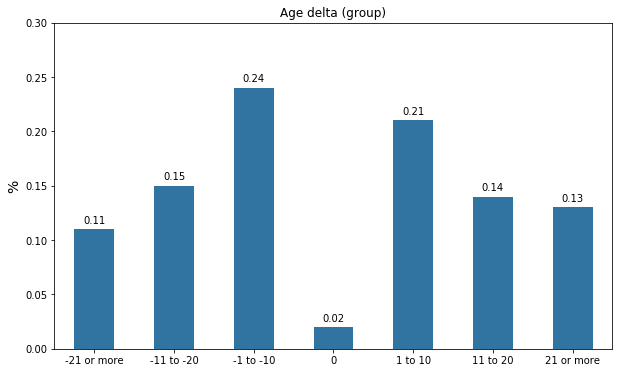

In [62]:
# visualize the data
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.pyplot.figure(dpi=2000) #improve the quality
plt.figure(figsize=(10, 6))
plt.title('Age delta (group)')
splot=sns.barplot(x="bucket", y="count", color = 'tab:blue', data=final_view)
splot.set(xlabel=None)  # remove the axis label
plt.ylim([0, 0.3])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel("%", size=14)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(splot, .5)